In [ ]:
from google.colab import drive
from google.colab import files
drive.mount('/content/drive')

import math
import numpy as np
import pandas as pd
import random as rng

#from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score, accuracy_score, roc_auc_score
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import StratifiedKFold

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

from datetime import datetime

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
try:
  import tensorflow as tf
except:
  !pip install tensorflow

In [ ]:
root_dir = '/content/drive/My Drive/Colab Notebooks/input/5610_cp2/'

data = []
images = []

for c in ['train','val','test']:
  entry = []
  entry.append(c + '.csv')
  
  df = pd.read_csv(root_dir + c + '.csv')
  df = df.drop(columns=['dim_lighting'])

  neg, pos = df.loc[df['labels'] == 0], df.loc[df['labels'] == 1]

  entry.append(neg)
  entry.append(pos)
  
  data.append(entry)
  images.append([neg['id'].values+'.jpg',pos['id'].values+'.jpg'])

print("Data ready for access.")

Data ready for access.


Preprocess

In [ ]:
images

[[array(['927038_290696464429549_954605866_a.jpg',
         '10251410_723894351000317_247391001_a.jpg',
         '10246020_288556491308755_710246161_a.jpg', ...,
         '10009910_652057734867841_740236625_a.jpg',
         '10012444_1416887038573122_1637530034_a.jpg',
         '10261069_660243480679684_196658136_a.jpg'], dtype=object),
  array(['925841_1379320535682879_1474261902_a.jpg',
         '1527778_603628736378746_739067185_a.jpg',
         '10251532_487806054654930_1571330517_a.jpg', ...,
         '1170356_1398757547067025_1273797068_a.jpg',
         '1597392_697327193621563_1803652645_a.jpg',
         '1516228_1409583249308157_77638523_a.jpg'], dtype=object)],
 [array(['1515902_234783130060013_1474850952_a.jpg',
         '10254103_1466255550270715_375891027_a.jpg',
         '10012606_733037363382962_643896142_a.jpg', ...,
         '10013274_1486873748198402_558088889_a.jpg',
         '10175168_805427622818304_376783766_a.jpg',
         '924958_510989432344292_1727141928_a.jpg

In [ ]:
sample_image = "10013096_1411349275795892_1104132420_a.jpg"

sel_group = None
groups = ['train','val','test']

for i in range(0,len(images)):
  for j in range(0,2):
    if sample_image in images[i][j]:
      sel_group = groups[i]

print(sel_group)

train


/content/drive/My Drive/Colab Notebooks/input/5610_cp2/train/10013096_1411349275795892_1104132420_a.jpg


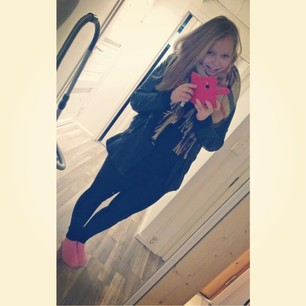

[-90.0, -90.0, -53.99925104583928, -54.141640223524895, 0.0, -45.0]
Angle is -54.0704


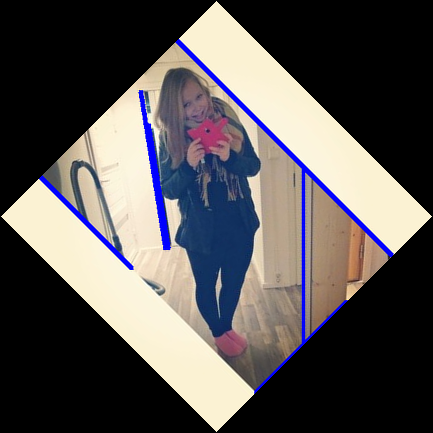

In [ ]:
import cv2
from google.colab.patches import cv2_imshow
from scipy import ndimage

#https://stackoverflow.com/questions/46731947/detect-angle-and-rotate-an-image-in-python

print(root_dir + sel_group + '/' + sample_image)

img_before = cv2.imread('/content/drive/My Drive/Colab Notebooks/input/5610_cp2/train/good/10013096_1411349275795892_1104132420_a.jpg')

cv2_imshow(img_before)    
key = cv2.waitKey(0)

img_gray = cv2.cvtColor(img_before, cv2.COLOR_BGR2GRAY)
img_edges = cv2.Canny(img_gray, 100, 100, apertureSize=3)
lines = cv2.HoughLinesP(img_edges, 1, math.pi / 180.0, 100, minLineLength=100, maxLineGap=5)

angles = []

for [[x1, y1, x2, y2]] in lines:
    cv2.line(img_before, (x1, y1), (x2, y2), (255, 0, 0), 3)
    angle = math.degrees(math.atan2(y2 - y1, x2 - x1))
    angles.append(angle)

#cv2_imshow(img_before)    
key = cv2.waitKey(0)

print(angles)

median_angle = np.median(angles)
#img_rotated = ndimage.rotate(img_before, median_angle)
img_rotated = ndimage.rotate(img_before, 45,)

print(f"Angle is {median_angle:.04f}")
#x= cv2.imwrite('rotated.jpg', 180*img_rotated/3.1415926)

cv2_imshow(img_rotated)

Do model

In [ ]:
fashion_mnist = tf.keras.datasets.fashion_mnist

(ftrain_images, ftrain_labels), (test_images, test_labels) = fashion_mnist.load_data()

In [ ]:
ftrain_images

In [ ]:
ftrain_labels

In [ ]:
from numpy import asarray
from PIL import Image

start_train_images = pd.read_csv(root_dir + 'train.csv')['id'].values + '.jpg'
start_train_labels = pd.read_csv(root_dir + 'train.csv')['labels'].values

start_train_labels

train_images = []

print("Loading train images...")
for i in range(0,len(start_train_images)):
  if i % len(start_train_images)/10 == 0: 
    print("\t", i, " images loaded.")
  tmp_image_str = start_train_images[i]
  print(tmp_image_str)
  tmp_image = Image.open(root_dir + 'train/' + tmp_image_str) 
  train_images.append(asarray(tmp_image))
print("Finished loading train images.")

In [ ]:
from tensorflow import keras

keras.backend.clear_session() # Clear cached model

import tensorflow as tf
import numpy as np
from tensorflow import keras
import os
import cv2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt

train = ImageDataGenerator(rescale=1/255)
test = ImageDataGenerator(rescale=1/255)

image_size = 306 #This is okay since they've been formatted as squares.

train_dataset = train.flow_from_directory(root_dir + 'train',
                                          target_size=(image_size,image_size),
                                          batch_size = 32,
                                          class_mode = 'binary')
                                         
val_dataset = test.flow_from_directory(root_dir + 'val',
                                        target_size=(image_size,image_size),
                                        batch_size =32,
                                        class_mode = 'binary')

model = keras.Sequential()

# Convolutional layer and maxpool layer 1
model.add(keras.layers.Conv2D(32,(3,3),activation='relu',input_shape=(image_size,image_size,3)))
model.add(keras.layers.MaxPool2D(2,2))

# Convolutional layer and maxpool layer 2
model.add(keras.layers.Conv2D(64,(3,3),activation='relu'))
model.add(keras.layers.MaxPool2D(2,2))

# Convolutional layer and maxpool layer 3
model.add(keras.layers.Conv2D(128,(3,3),activation='relu'))
model.add(keras.layers.MaxPool2D(2,2))

# Convolutional layer and maxpool layer 4
model.add(keras.layers.Conv2D(128,(3,3),activation='relu'))
model.add(keras.layers.MaxPool2D(2,2))

# This layer flattens the resulting image array to 1D array
model.add(keras.layers.Flatten())

# Hidden layer with 512 neurons and Rectified Linear Unit activation function 
model.add(keras.layers.Dense(512,activation='relu'))

# Output layer with single neuron which gives 0 for Cat or 1 for Dog 
#Here we use sigmoid activation function which makes our model output to lie between 0 and 1
model.add(keras.layers.Dense(1,activation='sigmoid'))

model.summary()

model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

history = model.fit()

In [ ]:
model.evaluate(validation_generator)

In [ ]:
STEP_SIZE_TEST=validation_generator.n//validation_generator.batch_size
validation_generator.reset()
preds = model.predict(validation_generator,
verbose=1)

In [ ]:
fpr, tpr, _ = roc_curve(validation_generator.classes, preds)
roc_auc = auc(fpr, tpr)
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()